<a href="https://colab.research.google.com/github/darshan-kale-dsi/Bank-Marketing-Campaign/blob/seb_branch/notebooks/model_adjustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Adjustment

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [2]:
dataframe = pd.read_csv('bank-full.csv', sep = ';')
# dataframe.head(5)

<Axes: >

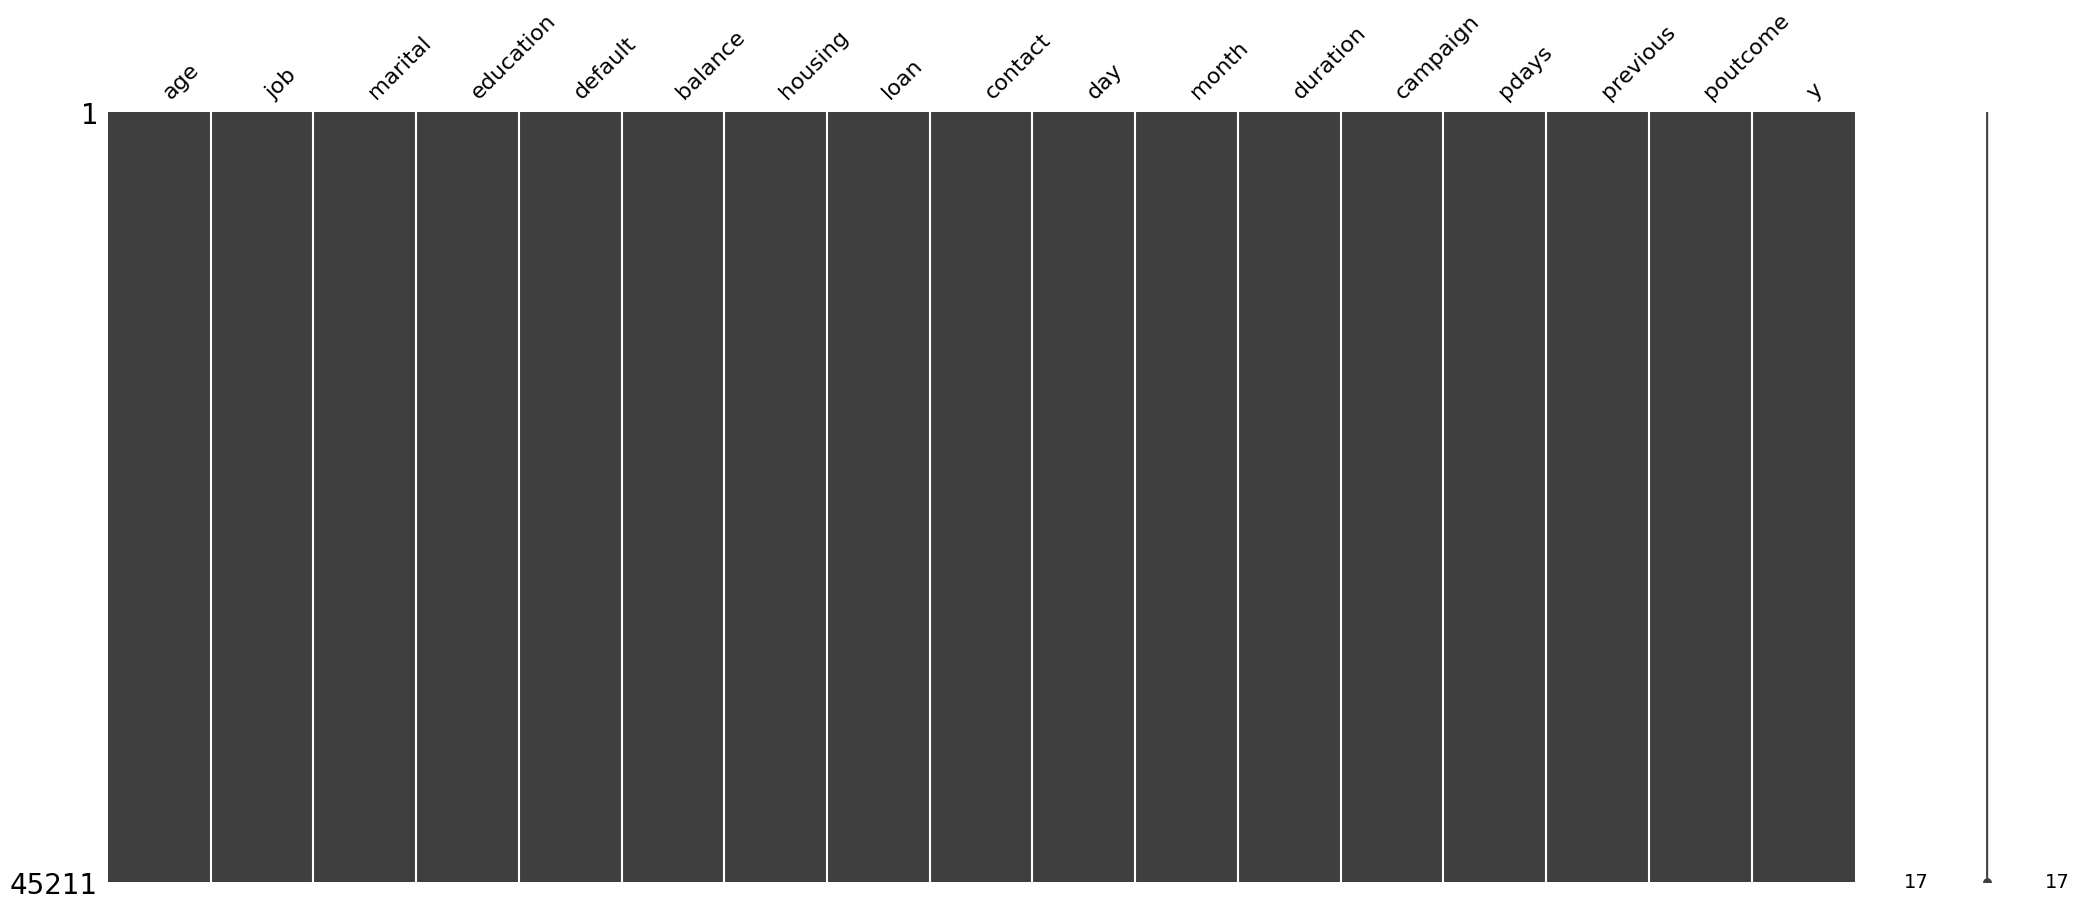

In [3]:
import missingno as msno
msno.matrix(dataframe)

In [4]:
# trimming extreme values (outliers)
dataframe = dataframe[(dataframe['balance']<10000) & (dataframe['duration']<1800)]

dataframe['pdays'] = dataframe['pdays'].apply(lambda value: 0 if value==-1 else 1 )
dataframe['default'] = dataframe['default'].apply(lambda value: 1 if value =='yes' else 0)
dataframe['housing'] = dataframe['housing'].apply(lambda value: 1 if value =='yes' else 0)
dataframe['loan'] = dataframe['loan'].apply(lambda value: 1 if value =='yes' else 0)
dataframe['y']= dataframe['y'].apply(lambda value: 1 if value =='yes' else 0)
dataframe['month'] = dataframe['month'].replace({'may':5,
                              'jun':6,
                              'jul':7,
                              'aug':8,
                              'oct':10,
                              'nov':11,
                              'dec':12,
                              'jan':1,
                              'feb':2,
                              'mar':3,
                              'apr':4,
                              'sep':9})



dataframe['day_sine'] = dataframe['day'].apply(lambda value: np.sin(2*value*np.pi/31))
dataframe['day_cosine'] = dataframe['day'].apply(lambda value: np.cos(2*value*np.pi/31))

dataframe['month_sine'] = dataframe['month'].apply(lambda value: np.sin(2*value*np.pi/12))
dataframe['month_cosine'] = dataframe['month'].apply(lambda value: np.cos(2*value*np.pi/12))


<ipython-input-4-d4326ba139e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['pdays'] = dataframe['pdays'].apply(lambda value: 0 if value==-1 else 1 )
<ipython-input-4-d4326ba139e8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['default'] = dataframe['default'].apply(lambda value: 1 if value =='yes' else 0)
<ipython-input-4-d4326ba139e8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [5]:
dataframe = dataframe.drop(['day', 'month'], axis = 1)

In [6]:
numeric_columns = ['age', 'default', 'balance', 'housing',
                   'loan', 'campaign', 'pdays', 'previous', 'day_sine',
                   'day_cosine', 'month_sine', 'month_cosine', 'duration']



categorical_columns = ['job','marital', 'education','contact','poutcome']
preprocessor = ColumnTransformer(
    transformers=[('num',StandardScaler(),numeric_columns),
                  ('cat',OneHotEncoder(drop='first'),categorical_columns)
                  ]
    )

from sklearn.pipeline import Pipeline
pipeline = Pipeline(  [
        ('preprocessor', preprocessor),
        # ('model', XGBClassifier())
        ('model', XGBClassifier(colsample_bytree = 0.5,
                      gamma = 0.0,
                      learning_rate = 0.1,
                      max_depth = 12,
                      reg_alpha = 1,
                      reg_lambda = 1e-5))
    ])

In [7]:
from imblearn.over_sampling import SMOTENC, SMOTE

X = dataframe.drop('y', axis = 1)
y = dataframe['y']

sm = SMOTENC(random_state=42,
             categorical_features = categorical_columns)

# sm = SMOTE(random_state=42)

X, y = sm.fit_resample(X, y)
# y.value_counts()

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 123)

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'default', 'balance',
                                                   'housing', 'loan',
                                                   'campaign', 'pdays',
                                                   'previous', 'day_sine',
                                                   'day_cosine', 'month_sine',
                                                   'month_cosine',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'poutcome'])])),
                ('model',
                 XGBClassifier(base_score...
                               feature_types=None, gamma=0.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score

Y_pred_train = pipeline.predict(X_train)
Y_pred_test = pipeline.predict(X_test)
Y_poba_train = pipeline.predict_proba(X_train)
Y_proba_test = pipeline.predict_proba(X_test)

res = {
    'accuracy_score_train': accuracy_score(y_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(y_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(y_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(y_test, Y_pred_test),
    'log_loss_train': log_loss(y_train, Y_poba_train),
    'log_loss_test': log_loss(y_test, Y_proba_test),
    'f1_score_train': f1_score(y_train, Y_pred_train),
    'f1_score_test': f1_score(y_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.9923743279677105,
 'accuracy_score_test': 0.950481781634867,
 'cohen_kappa_train': np.float64(0.984748684748337),
 'cohen_kappa_test': np.float64(0.9009618803734573),
 'log_loss_train': 0.047341713753743374,
 'log_loss_test': 0.11184063997736937,
 'f1_score_train': 0.9923402346003461,
 'f1_score_test': 0.9499484004127967}

In [11]:
y_hat = pipeline.predict(assessment)
print(accuracy_score(outcome, y_hat))
print(confusion_matrix(outcome, y_hat))
print(classification_report(outcome, y_hat))

NameError: name 'assessment' is not defined

In [ ]:
[3882  118]
 [ 163  358]

In [ ]:
y_hat = pipeline.predict(X_test)
print(accuracy_score(y_test, y_hat))
print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

In [ ]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipeline,
                         X, y,
                         cv=5,
                         scoring = scoring,
                         return_train_score = True)

In [ ]:
pd.DataFrame(d3_dict)

In [ ]:

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.8, 1.0],
    # "colsample_bytree": [0.8, 1.0],
    # "min_child_weight": [1, 3, 5],
    # "gamma": [0, 1, 5],
    # "reg_alpha": [0, 1, 10],
    # "reg_lambda": [0, 1, 10],
}

grid_cv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring = 'roc_auc',
    cv = 5,
    verbose = 1,
    n_jobs = -1)


grid_cv.fit(X_train, y_train)

In [ ]:
# def preprocessing_pipeline(dataframe):
#   binary_features = [
#                       'pdays',
#                       'default',
#                       'housing',
#                       'loan'
#                     ]
#   numeric_features = [
#                       'age',
#                       'balance',
#                       # 'duration',
#                       'campaign',
#                       'previous'
#                       ]
#   time_features = [
#                     'day_sine',
#                    'day_cosine',
#                    'month_sine',
#                    'month_cosine'
#                    ]
#   categorical_features = [
#                           'job',
#                           'marital',
#                           'education',
#                           'contact',
#                           'poutcome'
#                           ]

#   dataframe = dataframe[binary_features+numeric_features+time_features+categorical_features]

#   preprocessor = ColumnTransformer(transformers=[
#       ('num', StandardScaler(), numeric_features),
#       ('cat', OneHotEncoder(), categorical_features)
#   ])

#   dataframe_transformed = preprocessor.fit_transform(dataframe)

#   ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
#   final_columns = numeric_features + list(ohe_feature_names)
#   X_train_preprocessed_df = pd.DataFrame(dataframe_transformed, columns=final_columns)

#   X_train_preprocessed_df = pd.concat([X_train_preprocessed_df,dataframe[time_features].reset_index(drop = True)], axis = 1)
#   X_train_preprocessed_df = pd.concat([X_train_preprocessed_df,dataframe[binary_features].reset_index(drop = True)], axis = 1)


#   return X_train_preprocessed_df

In [ ]:
# import pandas as pd
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

# def preprocessing_pipeline(df):
#     """
#     Preprocess the input DataFrame by scaling numeric features, one-hot encoding categorical features,
#     and preserving time and binary features unchanged.

#     Parameters
#     ----------
#     df : pandas.DataFrame
#         The input DataFrame containing all necessary columns.

#     Returns
#     -------
#     df_preprocessed : pandas.DataFrame
#         A DataFrame with transformed numeric and categorical features, along with the original time and binary features.
#         The columns are ordered as: [scaled numeric features, one-hot encoded categorical features, time features, binary features].
#     """

#     # Define feature groups
#     binary_features = [
#                       # 'pdays',
#                       'default',
#                       'housing',
#                       'loan'
#                     ]
#     numeric_features = [
#                       'age',
#                       'balance',
#                       # 'duration',
#                       'campaign',
#                       'previous'
#                       ]
#     time_features = [
#                     'day_sine',
#                    'day_cosine',
#                    'month_sine',
#                    'month_cosine'
#                    ]
#     categorical_features = [
#                           'job',
#                           'marital',
#                           'education',
#                           'contact',
#                           # 'poutcome'
#                           ]



#     # Select and copy only the necessary columns
#     selected_columns = binary_features + numeric_features + time_features + categorical_features

#     df = df[selected_columns].copy()

#     # Create a ColumnTransformer to scale numeric features and one-hot encode categorical features
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', StandardScaler(), numeric_features),
#             ('cat', OneHotEncoder(), categorical_features)
#         ]
#     )

#     # Apply transformations on numeric and categorical features
#     transformed_array = preprocessor.fit_transform(df)

#     # Retrieve one-hot encoded feature names
#     cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

#     # Build DataFrame from the transformed numeric and categorical features
#     transformed_feature_names = numeric_features + list(cat_feature_names)
#     df_transformed = pd.DataFrame(transformed_array, columns=transformed_feature_names, index=df.index)

#     # Concatenate the unchanged time and binary features
#     df_preprocessed = pd.concat([df_transformed, df[time_features], df[binary_features]], axis=1)

#     return df_preprocessed


In [ ]:
# X_train_processed = preprocessing_pipeline(X_train)
# X_test_processed = preprocessing_pipeline(X_test)



In [ ]:
# from sklearn import ensemble as en
# import boruta as bt
# x_train_n = X_train_processed.values
# y_train_n = y_train.values.ravel()

# # Define model
# et = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# # Define boruta
# boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

In [ ]:
# cols_selected = boruta.support_.tolist()
# X_train_processed = X_train_processed[X_train_processed.iloc[:, cols_selected].columns.to_list()]
# X_test_processed = X_test_processed[X_train_processed.columns]

In [ ]:


# model = BernoulliNB()
# model = KNeighborsClassifier()
# model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
# model = RandomForestClassifier()
# model = XGBClassifier()
# model = XGBClassifier(colsample_bytree = 0.5,
#                       gamma = 0.0,
#                       learning_rate = 0.1,
#                       max_depth = 12,
#                       reg_alpha = 1,
#                       reg_lambda = 1e-5)
# 'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 12, 'reg_alpha': 1, 'reg_lambda': 1e-05

# model = LogisticRegression()
# model = svm.SVC()
# model.fit(X_train_processed, y_train)
# y_hat = model.predict(X_test_processed)
# print(accuracy_score(y_test, y_hat))
# print(confusion_matrix(y_test, y_hat))

In [ ]:
# assessment = pd.read_csv('bank.csv', sep = ';')
# outcome = assessment['y'].replace({'yes':1,'no':0})

In [ ]:



# import pandas as pd
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

# def preprocessing_pipeline(df):
#     """
#     Preprocess the input DataFrame by scaling numeric features, one-hot encoding categorical features,
#     and preserving time and binary features unchanged.

#     Parameters
#     ----------
#     df : pandas.DataFrame
#         The input DataFrame containing all necessary columns.

#     Returns
#     -------
#     df_preprocessed : pandas.DataFrame
#         A DataFrame with transformed numeric and categorical features, along with the original time and binary features.
#         The columns are ordered as: [scaled numeric features, one-hot encoded categorical features, time features, binary features].
#     """
#     # df = df[(df['balance']<10000) & (df['duration']<1800)]
#     df['pdays'] = df['pdays'].apply(lambda value: 0 if value==-1 else 1 )
#     df['default'] = df['default'].apply(lambda value: 1 if value =='yes' else 0)
#     df['housing'] = df['housing'].apply(lambda value: 1 if value =='yes' else 0)
#     df['loan'] = df['loan'].apply(lambda value: 1 if value =='yes' else 0)
#     df['y']= df['y'].apply(lambda value: 1 if value =='yes' else 0)
#     df['month'] = df['month'].replace({'may':5,
#                                 'jun':6,
#                                 'jul':7,
#                                 'aug':8,
#                                 'oct':10,
#                                 'nov':11,
#                                 'dec':12,
#                                 'jan':1,
#                                 'feb':2,
#                                 'mar':3,
#                                 'apr':4,
#                                 'sep':9})

#     df['day_sine'] = df['day'].apply(lambda value: np.sin(2*value*np.pi/31))
#     df['day_cosine'] = df['day'].apply(lambda value: np.cos(2*value*np.pi/31))

#     df['month_sine'] = df['month'].apply(lambda value: np.sin(2*value*np.pi/12))
#     df['month_cosine'] = df['month'].apply(lambda value: np.cos(2*value*np.pi/12))

#     # Define feature groups
#     binary_features = [
#                       # 'pdays',
#                       'default',
#                       'housing',
#                       'loan'
#                     ]
#     numeric_features = [
#                       'age',
#                       'balance',
#                       # 'duration',
#                       'campaign',
#                       'previous'
#                       ]
#     time_features = [
#                     'day_sine',
#                    'day_cosine',
#                    'month_sine',
#                    'month_cosine'
#                    ]
#     categorical_features = [
#                           'job',
#                           'marital',
#                           'education',
#                           'contact',
#                           # 'poutcome'
#                           ]



#     # Select and copy only the necessary columns
#     selected_columns = binary_features + numeric_features + time_features + categorical_features

#     df = df[selected_columns].copy()

#     # Create a ColumnTransformer to scale numeric features and one-hot encode categorical features
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', StandardScaler(), numeric_features),
#             ('cat', OneHotEncoder(), categorical_features)
#         ]
#     )

#     # Apply transformations on numeric and categorical features
#     transformed_array = preprocessor.fit_transform(df)

#     # Retrieve one-hot encoded feature names
#     cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

#     # Build DataFrame from the transformed numeric and categorical features
#     transformed_feature_names = numeric_features + list(cat_feature_names)
#     df_transformed = pd.DataFrame(transformed_array, columns=transformed_feature_names, index=df.index)

#     # Concatenate the unchanged time and binary features
#     df_preprocessed = pd.concat([df_transformed, df[time_features], df[binary_features]], axis=1)

#     return df_preprocessed


In [ ]:
# assessment = preprocessing_pipeline(assessment)

In [ ]:
# y_hat_assessment = model.predict(assessment)

In [ ]:
# print(accuracy_score(outcome, y_hat_assessment))
# print(confusion_matrix(outcome, y_hat_assessment))

In [ ]:
# outcome

In [ ]:
# from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

# # Space
# space = {
#     'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
#     'max_depth' : hp.choice('max_depth', range(3,21,3)),
#     'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
#     'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
#     'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),
#     'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
# }

# # Set up the k-fold cross-validation
# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


# # Objective function
# def objective(params):
#   xgboost = XGBClassifier(seed=0, **params)
#   score = cross_val_score(estimator=xgboost,
#                             X=X_train_processed,
#                             y=y_train,
#                             cv=kfold,
#                             scoring='average_precision',
#                             n_jobs=-1).mean()
#   # Loss is negative score
#   loss = - score
#   # Dictionary with information for evaluation
#   return {'loss': loss, 'params': params, 'status': STATUS_OK}

# # Optimize
# best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())

# # Print the values of the best parameters
# print(space_eval(space, best))

In [ ]:


# # Define the parameter grid
# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.001],
#     "subsample": [0.8, 1.0],
#     # "colsample_bytree": [0.8, 1.0],
#     # "min_child_weight": [1, 3, 5],
#     # "gamma": [0, 1, 5],
#     # "reg_alpha": [0, 1, 10],
#     # "reg_lambda": [0, 1, 10],
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator = model,
#     param_grid = param_grid,
#     scoring = "roc_auc",
#     cv = 5,
#     verbose = 1,
#     n_jobs = -1
# )

# # Fit the grid search
# final = grid_search.fit(X_train_processed, y_train)
# y_test = final.predict(X_test_processed)
# print(accuracy_score(y_test, y_hat))
# print(confusion_matrix(y_test, y_hat))

# # Print the best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)


In [12]:
assessment = pd.read_csv('bank.csv', sep = ';')

# trimming extreme values (outliers)
# assessment = assessment[(dataframe['balance']<10000) & (dataframe['duration']<1800)]

assessment['pdays'] = assessment['pdays'].apply(lambda value: 0 if value==-1 else 1 )
assessment['default'] = assessment['default'].apply(lambda value: 1 if value =='yes' else 0)
assessment['housing'] = assessment['housing'].apply(lambda value: 1 if value =='yes' else 0)
assessment['loan'] = assessment['loan'].apply(lambda value: 1 if value =='yes' else 0)
assessment['y']= assessment['y'].apply(lambda value: 1 if value =='yes' else 0)
assessment['month'] = assessment['month'].replace({'may':5,
                              'jun':6,
                              'jul':7,
                              'aug':8,
                              'oct':10,
                              'nov':11,
                              'dec':12,
                              'jan':1,
                              'feb':2,
                              'mar':3,
                              'apr':4,
                              'sep':9})



assessment['day_sine'] = assessment['day'].apply(lambda value: np.sin(2*value*np.pi/31))
assessment['day_cosine'] = assessment['day'].apply(lambda value: np.cos(2*value*np.pi/31))

assessment['month_sine'] = assessment['month'].apply(lambda value: np.sin(2*value*np.pi/12))
assessment['month_cosine'] = assessment['month'].apply(lambda value: np.cos(2*value*np.pi/12))

<ipython-input-12-99c16a99251b>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  assessment['month'] = assessment['month'].replace({'may':5,


In [13]:
output = pd.DataFrame(pipeline.predict_proba(assessment), columns = ['no','yes'] )

In [14]:
assessment_final = pd.read_csv('bank.csv', sep = ';')

In [15]:
final = pd.concat([assessment_final, output],axis = 1)

In [36]:
final.sort_values('yes', ascending = False).head(50)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,no,yes
855,46,management,divorced,tertiary,no,624,no,no,cellular,17,sep,336,2,183,2,success,yes,0.028334,0.971666
4229,62,self-employed,divorced,tertiary,no,6,yes,no,cellular,13,oct,216,1,183,4,success,yes,0.029746,0.970254
3256,36,management,married,tertiary,no,495,no,no,cellular,12,mar,213,3,182,6,success,yes,0.033034,0.966966
2122,48,unemployed,married,secondary,no,817,no,no,cellular,14,jan,517,1,282,4,success,yes,0.033732,0.966268
3385,38,unknown,single,tertiary,no,0,no,no,cellular,11,sep,260,3,95,3,success,yes,0.034856,0.965144
4009,38,housemaid,divorced,secondary,no,70,no,no,cellular,27,oct,255,3,148,1,success,yes,0.035270,0.964730
509,30,blue-collar,single,secondary,no,315,no,no,cellular,23,jun,1407,1,-1,0,unknown,yes,0.038227,0.961773
2372,43,services,single,secondary,no,3403,yes,no,cellular,12,nov,707,2,97,2,success,yes,0.041495,0.958505
3250,54,technician,married,tertiary,no,876,no,no,cellular,27,oct,269,3,541,3,success,yes,0.042833,0.957167
3881,44,technician,single,secondary,no,1679,no,no,telephone,20,oct,718,1,-1,0,unknown,yes,0.043260,0.956740


In [28]:
cat_encoder = pipeline.named_steps['preprocessor'].transformers_[1][1]
cat_features = cat_encoder.get_feature_names_out(categorical_columns)

In [32]:
features = np.concatenate([numeric_columns,cat_features])

In [30]:
import shap
explainer = shap.TreeExplainer(pipeline['model'])


In [18]:
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

In [19]:
shap_values = explainer.shap_values(X_train_transformed)

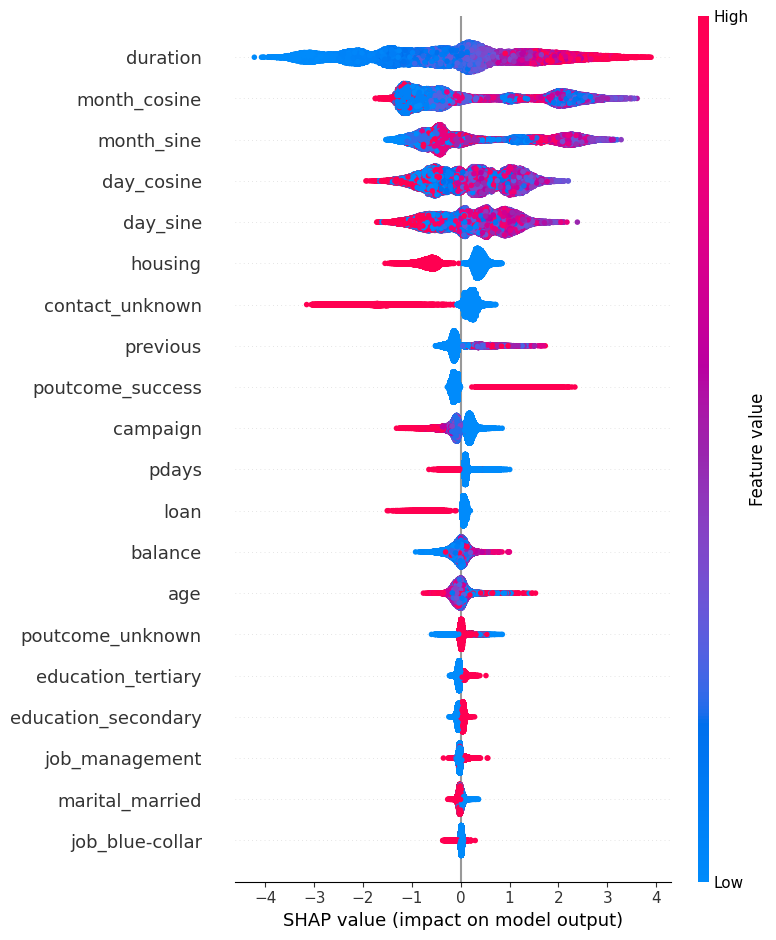

In [35]:
shap.summary_plot(shap_values, X_train_transformed, feature_names = features)